# Spark Streaming - Part 2.B
__Authors__ : Ladji Idrissa FOFANA & Zakaria TOZY

Spark Streaming application that connects to Part2.A, extracts hashtags, and displays the 10 most popular hashtag.

__Run the notebook Part2_A.ipynb first__

In [1]:
import findspark

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession,SQLContext
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt

In [2]:
#Create a new SparkSession and StreamingContext
spark = SparkSession.builder.appName("TwitterTrends").master("local[2]").getOrCreate()
ssc = StreamingContext(spark.sparkContext, 10)

#Set log level to "ERROR" to reduce the amount of log messages
spark.sparkContext.setLogLevel("ERROR")

#Set checkpoint location and create a new DStream
ssc.checkpoint("TwitterTrends_checkpoint")
socket_stream = ssc.socketTextStream('localhost', 5554)

# Split the lines by newline character to get individual tweets
tweets = socket_stream.flatMap(lambda text: text.split("\n"))
tweets = tweets.map(lambda tweet: tweet.lower())

# Split each tweet by space character to get individual words and get hashtags
words = tweets.flatMap(lambda tweet: tweet.split(" "))
hashtags = words.filter(lambda word: word.startswith("#"))

#Map each hashtag to a tuple of (hashtag, 1) to get paired hashtags
paired_hashtags = hashtags.map(lambda word: (word, 1))

#Count paired hashtags by window and slide for 10 min = 600 sec
counts = paired_hashtags.reduceByKeyAndWindow(lambda a, b: a + b, None, 600, 600)

#Filter only the hashtags which are mentioned more than 5 times
filtered_hashtags = counts.filter(lambda hashtag_count: hashtag_count[1] > 5)

#Sort the filtered hashtags
most_popular_hashtags = filtered_hashtags.transform(lambda rdd: rdd.sortBy(lambda x: x[1],ascending=False))
most_popular_hashtags.pprint(10)

#Plot the top 10 hashtags
def process_rdd(rdd):
    # Get the top 10 hashtags and their counts
    top_10_hashtags = rdd.take(10)
    # Extract the hashtags and counts into separate lists
    hashtags = [word[0] for word in top_10_hashtags]
    counts = [word[1] for word in top_10_hashtags]

    # Plot a bar chart of the top 10 hashtags
    plt.barh(hashtags, counts)
    plt.xlabel('Hashtag')
    plt.ylabel('Count')
    plt.title('Top 10 Hashtags')
    plt.show()

most_popular_hashtags.foreachRDD(process_rdd)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/20 20:35:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/20 20:35:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


-------------------------------------------
Time: 2023-01-20 20:45:50
-------------------------------------------
('#crypto', 185)
('#bitcoin', 67)
('#music', 63)
('#eth', 41)
('#btc', 34)
('#ethereum', 28)
('#cryptocurrency', 28)
('#nft', 26)
('#bsc', 25)
('#onairnow', 24)
...



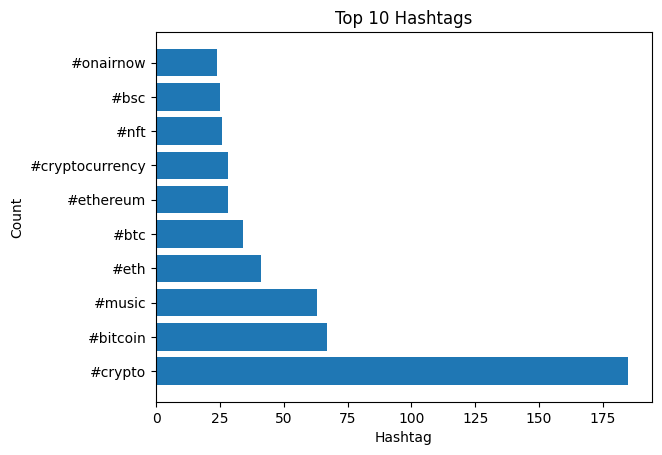

In [3]:
ssc.start() # Start the computation 

In [4]:
ssc.stop()

23/01/20 20:46:13 ERROR ReceiverTracker: Deregistered receiver for stream 0: Stopped by driver


Exception in thread "receiver-supervisor-future-0" java.lang.Error: java.lang.InterruptedException: sleep interrupted
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1155)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.InterruptedException: sleep interrupted
	at java.lang.Thread.sleep(Native Method)
	at org.apache.spark.streaming.receiver.ReceiverSupervisor.$anonfun$restartReceiver$1(ReceiverSupervisor.scala:196)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurren